## Learning diffusivity (m) to solution (u) map for Poisson problem (Implementation 2)

Data is located in `../data` directory, and key data of our interest is in `Poisson_samples.npz` file. We would also need the mesh data in files with names `Poisson_m_mesh` and `Poisson_u_mesh` for plotting.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results_implement2/neural_operator_prediction_comparison.png" width="800"> </p>

In [3]:
import sys
import os

import torch
import numpy as np

util_path = "../../../utilities/"
sys.path.append(util_path)
from plotUtilities import *
from dataMethods import DataProcessorFNO
from torch_fno2d import FNO2D

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
data_folder = '../data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results_implement2/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [5]:
num_train = 3500
num_test = 1000

num_Y_components = 1 # scalar field

coarsen_grid_factor = 1 # select every coarsen_grid_factor-th point so that we can coarsen the grid

# training hyperparameters
batch_size = 20
epochs = 500
lr = 1.0e-3

data_prefix = 'Poisson'
data = DataProcessorFNO(data_folder + data_prefix + '_FNO_samples.npz', num_train, num_test, num_Y_components, coarsen_grid_factor)

train_data = {'X_train': data.X_train, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'Y_train': data.Y_test}

# get data to save
data_to_save = data.get_data_to_save()

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)

X_train: torch.Size([3500, 51, 51, 3])
Y_train: torch.Size([3500, 51, 51, 1])
X_test: torch.Size([1000, 51, 51, 3])
Y_test: torch.Size([1000, 51, 51, 1])


## Create model and train the network

In [8]:
num_layers = 3
width = 20 # dimension of hidden output space
fourier_modes1 = 8
fourier_modes2 = 8

model_save_path = results_dir + 'FNO/'
model_save_file = model_save_path + 'model.pkl'
model_save_data_and_info_file = model_save_path + 'data_and_info'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model = FNO2D(num_layers, width, fourier_modes1, fourier_modes2, \
              num_Y_components, save_file = model_save_file)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: {}'.format(trainable_params))

Number of trainable parameters: 154961


In [9]:
# save the data and info
data_to_save = data.get_data_to_save()
np.savez(model_save_data_and_info_file + '.npz', \
             data_to_save = data_to_save, \
             num_train = num_train, num_test = num_test, \
             num_Y_components = num_Y_components, \
             num_layers = num_layers, \
             width = width, \
             fourier_modes1 = fourier_modes1, \
             fourier_modes2 = fourier_modes2, \
             epochs = epochs, \
             batch_size = batch_size, \
             lr = lr)


In [10]:
# Train
model.train(train_data, test_data, batch_size=batch_size, \
            epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)

--------------------------------------------------
Starting training with 154961 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 3.981e-01, Test Loss (l2 squared): 2.089e-01, Time (sec): 11.121
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 7.109e-03, Test Loss (l2 squared): 6.852e-03, Time (sec): 12.729
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 5.070e-03, Test Loss (l2 squared): 5.449e-03, Time (sec): 9.767
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 200
--

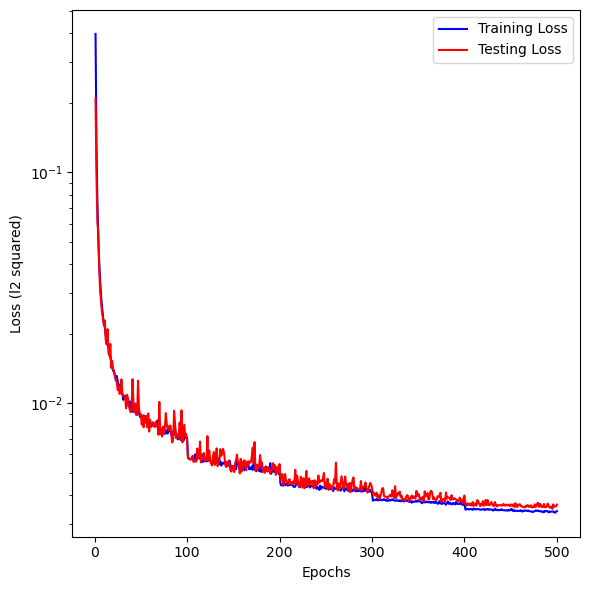

In [11]:
## Plotting the loss history
num_epoch = model.train_loss_log.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, model.train_loss_log[:, 0], color='blue', label='Training Loss')
ax.plot(x, model.test_loss_log[:, 0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss (l2 squared)')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

# Save the model

In [12]:
# not needed as the model will be saved at the end of training
torch.save(model, model_save_file)

## Test and plot the output of network

In [13]:
# load the model
model = torch.load(model_save_file)
print('Model loaded from:', model_save_file)
print('Model:', model)

Model loaded from: /home/prashant/Dropbox/Work/Simulations/neuralnet_works/error_corrector_direction/neural_operators_survey/problems/poisson/FNO/Results_implement2/FNO/model.pkl
Model: FNO2D(
  (fno_layers): ModuleList(
    (0-2): 3 x FNO2DLayer(
      (w): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (input_projector): Linear(in_features=3, out_features=20, bias=True)
  (output_projector): Linear(in_features=20, out_features=1, bias=True)
)


/tmp/ipykernel_91963/4118623201.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_save_file)


In [14]:
Y_test = test_data['Y_train'].detach().numpy()
Y_test_pred = model.predict(test_data['X_train']).detach().numpy()

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

a = Y_test.reshape(Y_test.shape[0], -1)
b = Y_test_pred.reshape(Y_test_pred.shape[0], -1)
print('a shape: {}, b shape: {}'.format(a.shape, b.shape))

error = np.linalg.norm(a - b, axis = 1)/np.linalg.norm(a, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (1000, 51, 51, 1), test_pred shape: (1000, 51, 51, 1)
a shape: (1000, 2601), b shape: (1000, 2601)
Num tests:  1000, Mean Loss (rel l2): 7.051e-02, Std Loss (rel l2): 2.172e-02


In [15]:
i_plot = 0
i_pred = Y_test_pred[i_plot]
i_truth = Y_test[i_plot]
i_m_test = data.X_test[i_plot]
print('i_pred shape: {}, i_truth shape: {}, i_m_test shape: {}'.format(i_pred.shape, i_truth.shape, i_m_test.shape))

i_pred shape: (51, 51, 1), i_truth shape: (51, 51, 1), i_m_test shape: torch.Size([51, 51, 3])


In [16]:
def apply_grid_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids[:, 0], bc_node_ids[:,1]] = bc_value
    return u

i_plot =   993, error (rel l2): 6.185e-03
i_plot =   859, error (rel l2): 5.416e-03
i_plot =   298, error (rel l2): 5.194e-03
i_plot =   553, error (rel l2): 5.249e-03


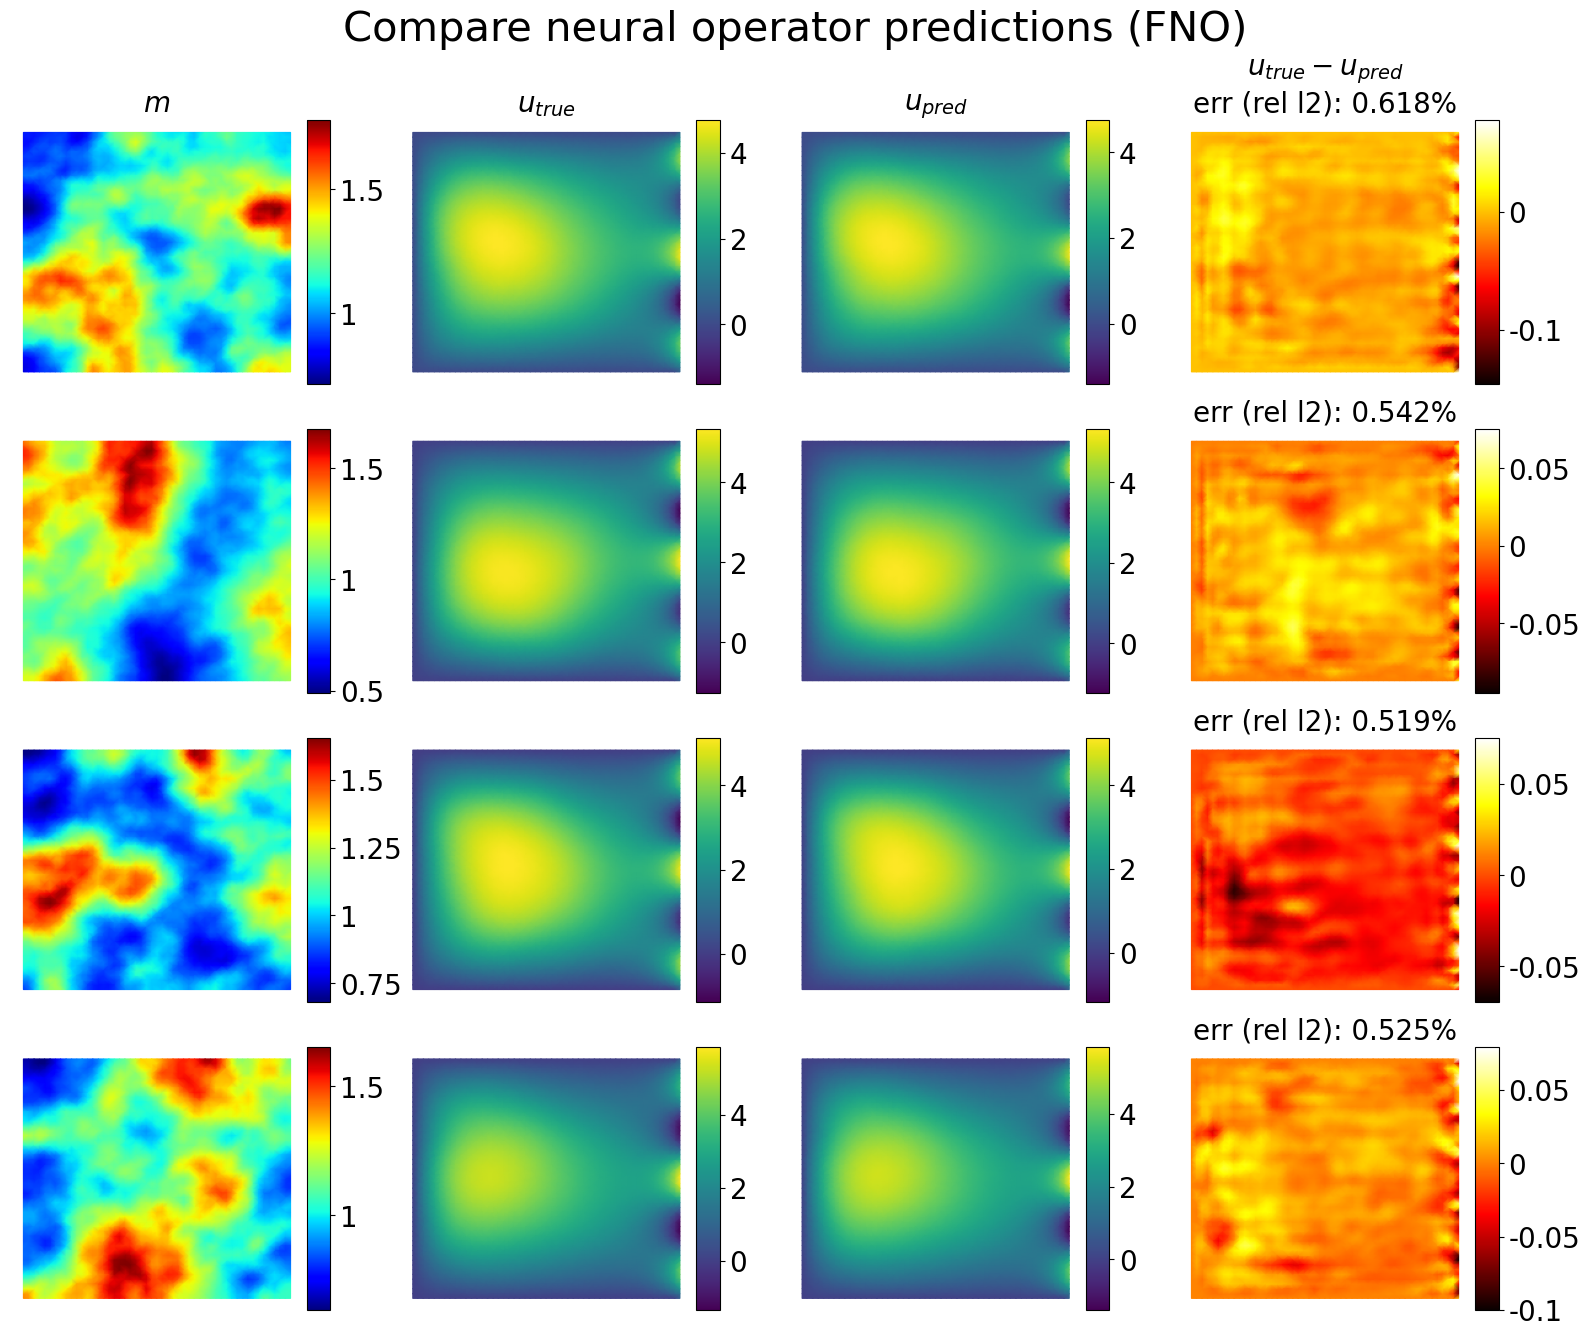

In [17]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True
apply_dirichlet_bc_flag = True

# row: m, u_true, u_pred, u_diff
u_tags = [r'$m$', r'$u_{true}$', r'$u_{pred}$', r'$u_{true} - u_{pred}$']
cmaps = ['jet', 'viridis', 'viridis', 'hot']

grid_x, grid_y = data.grid_x_test[0], data.grid_y_test[0]

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)[:, :, 0]
        i_truth = data.decoder_Y(i_truth)[:, :, 0]
        i_m_test = data.decoder_X(i_m_test)[:, :, 0]
    else:
        i_pred = i_pred[:, :, 0]
        i_truth = i_truth[:, :, 0]
        i_m_test = i_m_test[:, :, 0]
    if apply_dirichlet_bc_flag:
        i_pred = apply_grid_dirichlet_bc(i_pred, 0.0, data.u_grid_dirichlet_boundary_nodes)
        i_truth = apply_grid_dirichlet_bc(i_truth, 0.0, data.u_grid_dirichlet_boundary_nodes)
        # # verify for i_truth
        # a = i_truth[i, data.u_grid_dirichlet_boundary_nodes[:,0], data.u_grid_dirichlet_boundary_nodes[:,1]]
        # if np.abs(a).max() > 1.0e-9:
        #     print('Warning: Dirichlet BC not applied to i_truth. Err : {}'.format(a.max()))
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff.flatten()) / np.linalg.norm(i_truth.flatten())
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        
        cbar = field_plot_grid(axs[i,j], uvec[j], grid_x, grid_y, cmap = cmaps[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm*100)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Compare neural operator predictions ({})'.format(model.name), fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()


# Scratch

### torch fno implementation blocks

In [13]:
# load data
num_train, num_test = 50, 20
data = np.load(data_folder + 'Poisson_FNO_samples.npz')
x_train = data['grid_m_samples'][:num_train]
x_test = data['grid_m_samples'][num_train:(num_train + num_test)]
y_train = data['grid_u_samples'][:num_train]
y_test = data['grid_u_samples'][num_train:(num_train + num_test)]
nx, ny = x_train.shape[1], x_train.shape[2]
print('nx: {}, ny: {}'.format(nx, ny))
print('x_train shape: {}, y_train shape: {}'.format(x_train.shape, y_train.shape))
print('x_test shape: {}, y_test shape: {}'.format(x_test.shape, y_test.shape))

grid_x_train = np.tile(data['grid_x'], (num_train, 1, 1)).reshape(num_train, nx, ny, 1)
grid_y_train = np.tile(data['grid_y'], (num_train, 1, 1)).reshape(num_train, nx, ny, 1)
print('grid_x_train shape: {}, grid_y_train shape: {}'.format(grid_x_train.shape, grid_y_train.shape))

grid_x_test = np.tile(data['grid_x'], (num_test, 1, 1)).reshape(num_test, nx, ny, 1)
grid_y_test = np.tile(data['grid_y'], (num_test, 1, 1)).reshape(num_test, nx, ny, 1)
print('grid_x_test shape: {}, grid_y_test shape: {}'.format(grid_x_test.shape, grid_y_test.shape))

x_train = x_train.reshape(num_train, nx, ny, 1)
x_test = x_test.reshape(num_test, nx, ny, 1)
print('x_train shape: {}, x_test shape: {}'.format(x_train.shape, x_test.shape))

XX_train = np.concatenate((x_train, grid_x_train, grid_y_train), axis = -1)
XX_test = np.concatenate((x_test, grid_x_test, grid_y_test), axis = -1)
XX_train = torch.from_numpy(XX_train).to(torch.float32)
XX_test = torch.from_numpy(XX_test).to(torch.float32)
YY_train = torch.from_numpy(y_train).to(torch.float32)
YY_test = torch.from_numpy(y_test).to(torch.float32)

print('XX_train shape: {}, XX_test shape: {}'.format(XX_train.shape, XX_test.shape))   


width = 32 # number of channels in hidden layer
modes = 8  # number of Fourier modes to keep 
batch_size = 4
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(XX_train, YY_train), batch_size=batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(XX_test, YY_test), batch_size=batch_size, shuffle=True)

nx: 51, ny: 51
x_train shape: (50, 51, 51), y_train shape: (50, 51, 51)
x_test shape: (20, 51, 51), y_test shape: (20, 51, 51)
grid_x_train shape: (50, 51, 51, 1), grid_y_train shape: (50, 51, 51, 1)
grid_x_test shape: (20, 51, 51, 1), grid_y_test shape: (20, 51, 51, 1)
x_train shape: (50, 51, 51, 1), x_test shape: (20, 51, 51, 1)
XX_train shape: torch.Size([50, 51, 51, 3]), XX_test shape: torch.Size([20, 51, 51, 3])


In [14]:
# creat data
x, y = next(iter(train_loader))
print('x shape: {}, y shape: {}'.format(x.shape, y.shape))


s_conv = SpectralConv2d(width, width, modes, modes)
w_1d = nn.Conv1d(width, width, 1)
w_2d = nn.Conv2d(width, width, 1)

f0 = nn.Linear(3, width)
f1 = nn.Linear(width, 1)
print('w: {}, \nf1: {}, \nf2: {}'.format(w, f1, f2))

# apply projection
x = f0(x)
print('x shape: {}'.format(x.shape))
x = x.permute(0, 3, 1, 2)
print('x shape: {}'.format(x.shape))

x_w1d = w_1d(x.view(batch_size, width, -1)).view(batch_size, width, nx, ny)
x_w2d = w_2d(x)
print('x_w1d shape: {}'.format(x_w1d.shape))
print('x_w2d shape: {}'.format(x_w2d.shape))

x_scon = s_conv(x)
print('x_scon shape: {}'.format(x_scon.shape))

x = x_scon + x_w1d
print('x shape: {}'.format(x.shape))

x = nnF.gelu(x)
print('x shape: {}'.format(x.shape))

x = x.permute(0, 2, 3, 1)
print('x shape: {}'.format(x.shape))

x = f1(x)
print('x shape: {}'.format(x.shape))

y = x.reshape(batch_size, -1)
print('y shape: {}'.format(y.shape))

x shape: torch.Size([4, 51, 51, 3]), y shape: torch.Size([4, 51, 51])


NameError: name 'SpectralConv2d' is not defined

### array operations

In [ ]:
nx, ny = 4, 4
a, b = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))
print('a: \n{}'.format(a))

def f(x,y):
    return 100*x + y

fab = f(a, b)
print('fab: \n{}'.format(fab))


a = a.flatten()
print('a: \n{}'.format(a))

c = np.vstack((a, b.flatten())).T
print('c: \n{}'.format(c))

fc = f(c[:,0], c[:,1])
print('fc: \n{}'.format(fc))

a: 
[[0.         0.33333333 0.66666667 1.        ]
 [0.         0.33333333 0.66666667 1.        ]
 [0.         0.33333333 0.66666667 1.        ]
 [0.         0.33333333 0.66666667 1.        ]]
fab: 
[[  0.          33.33333333  66.66666667 100.        ]
 [  0.33333333  33.66666667  67.         100.33333333]
 [  0.66666667  34.          67.33333333 100.66666667]
 [  1.          34.33333333  67.66666667 101.        ]]
a: 
[0.         0.33333333 0.66666667 1.         0.         0.33333333
 0.66666667 1.         0.         0.33333333 0.66666667 1.
 0.         0.33333333 0.66666667 1.        ]
c: 
[[0.         0.        ]
 [0.33333333 0.        ]
 [0.66666667 0.        ]
 [1.         0.        ]
 [0.         0.33333333]
 [0.33333333 0.33333333]
 [0.66666667 0.33333333]
 [1.         0.33333333]
 [0.         0.66666667]
 [0.33333333 0.66666667]
 [0.66666667 0.66666667]
 [1.         0.66666667]
 [0.         1.        ]
 [0.33333333 1.        ]
 [0.66666667 1.        ]
 [1.         1.        ]]

In [ ]:
grid_x, grid_y = data.grid_x_test[0], data.grid_y_test[0]
print('data.X_train_mean.shape:',data.X_train_mean.shape)

N = 5

X_mean = data.X_train_mean
X_std = data.X_train_std
tol = data.tol
print('X_mean.shape: {}, X_std.shape: {}'.format(X_mean.shape, X_std.shape))

X_train_enc = data.X_train.detach().numpy()
X_train_enc = X_train_enc[:N]
print('X_train_enc.shape:',X_train_enc.shape)

# understand the encoder and decoder when using in batch or single mode
print('batch mode test')

X_train_raw = data.data['grid_m_samples'][:N, :, :]
X_train_raw_enc = X_train_raw.copy()
print('X_train_raw.shape:',X_train_raw.shape)   
for i in range(N):
    X_train_raw_enc[i,:,:] = (X_train_raw[i,:,:] - X_mean[:,:,0]) / (X_std[:,:,0] + tol)

    err = X_train_enc[i][:,:,0] - X_train_raw_enc[i]
    print('enc err:',np.linalg.norm(err))

X_train_dec = data.decoder_X(X_train_enc)
print('X_train_dec.shape:',X_train_dec.shape)   
X_train_raw_dec = X_train_raw_enc.copy()
for i in range(N):
    X_train_raw_dec[i] = X_train_raw_enc[i] * (X_std[:, :, 0] + tol) + X_mean[:,:,0]

    err = X_train_raw_dec[i] - X_train_dec[i][:,:,0]
    print('dec err:',np.linalg.norm(err))

print('single mode test')
for i in range(N):
    X_train_dec[i] = data.decoder_X(X_train_enc[i])
    X_train_raw_dec[i] = X_train_raw_enc[i] * (X_std[:, :, 0] + tol) + X_mean[:,:,0]
    err = X_train_raw_dec[i] - X_train_dec[i][:,:,0]
    print('dec err:',np.linalg.norm(err))

# m_from_X_train = data.decoder_X(data.X_train[4])
# m_from_data = data.data['grid_m_samples'][4, :, :]

# print('m_from_X_train.shape:',m_from_X_train.shape)
# print('m_from_data.shape:',m_from_data.shape)

# quick_field_plot_grid(m_from_data, grid_x, grid_y, title= 'm from data')
# quick_field_plot_grid(m_from_X_train[:, :, 0], grid_x, grid_y, title= 'm from X_train')

for i in range(N):
    quick_field_plot_grid(X_train_raw_dec[i], grid_x, grid_y, title= 'X_train_raw_dec')
    quick_field_plot_grid(X_train_dec[i][:,:,0], grid_x, grid_y, title= 'X_train_dec')

data.X_train_mean.shape: (51, 51, 1)
X_mean.shape: (51, 51, 1), X_std.shape: (51, 51, 1)
X_train_enc.shape: (5, 51, 51, 3)
batch mode test
X_train_raw.shape: (5, 51, 51)
enc err: 5.0674907541272214e-08
enc err: 1.747372050832044e-06
enc err: 1.0660851706135477e-06
enc err: 1.2704581741636348e-06
enc err: 1.1664190855274301e-06
X_train_dec.shape: (5, 51, 51, 3)
dec err: 3.439578254780765e-09
dec err: 1.0903854263089724e-07
dec err: 7.022732448365504e-08
dec err: 8.603134588028868e-08
dec err: 7.558886984508893e-08
single mode test


ValueError: could not broadcast input array from shape (51,51,51) into shape (51,51)